In [62]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, r2_score, mean_squared_error
from sklearn.feature_selection import SelectKBest, f_classif, RFE, chi2, SequentialFeatureSelector
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from lazypredict.Supervised import LazyClassifier
from IPython.display import display

pd.options.display.float_format = '{:,.4f}'.format

In [63]:
# Data Loader loads data from UCI-ML Repo
def load_datasets():
    # Classification Datasets
    c_cancer = pd.read_csv("./Classification.CancerMB.csv").iloc[:, :32]
    c_mice_expression = pd.read_csv("./Classification.Mice.Expression.csv")#.iloc[:, :25]
    c_adult_income = pd.read_csv("./Classification.Adult.Income.csv")
    # Regression Datasets
    r_life_expectancy = pd.read_csv("./Regression.Life.Expectancy.csv")
    r_appartment_rent = pd.read_csv("./Regression.Appartment.Rent.csv")
    r_song_popularity = pd.read_csv("./Regression.Song.Popularity.csv")
    
    return c_cancer, c_mice_expression, c_adult_income, r_life_expectancy, r_appartment_rent, r_song_popularity

In [64]:
# This function performs a missing value analysis on each column of the dataset, helps you decide on what to do in cleaning process
def null_check(df):
    null_columns = []
    for column in df.columns:
        print("Column Name:", column)
        print("Column DataType:", df[column].dtype)
        if df[column].dtype != 'float64' and df[column].dtype != 'int64':
            print("Column unique values:", df[column].unique())
        print("Column has null:", df[column].isnull().any())

        
        if df[column].isnull().any() == True:
            print("Column Null Count:", df[column].isnull().sum())
            null_columns.append(column)
        print("\n")
    return null_columns

In [65]:
# This function drops any null columns and missing values
# This is where you decide whether to remove NULL rows (which will reduce the size of Dataset) or remove NULL columns entirely. You can also choose a combination of both.
def clean_data(df, drop_columns, missing_value = False):
    # Remove unnecessary columns
    df.drop(drop_columns, axis=1, inplace=True)
    # Drop rows with any missing values
    if missing_value == False:
        df.dropna(inplace=True)
    else:
        df.fillna(missing_value, inplace=True)
    return df

In [66]:
# Transforms categorical and numberical data into numerical data
def transform_data(df):
    # Encode categorical variables
    label_encoder = LabelEncoder()
    print("Categorical columns:", df.select_dtypes(include=['object']).columns)
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = label_encoder.fit_transform(df[col])
    
    # Standardize numerical features
    scaler = StandardScaler()
    print("Numerical columns:", df.select_dtypes(include=['float64', 'int64']).columns)
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    if len(numerical_cols) > 0:
        df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    return df

In [83]:
def ApplyRegular(X, y, cv, model):
    results = []
    scores = cross_val_score(model, X, y, cv=cv)
    results.append(scores.mean())
    print(f"Regular{model}: {scores.mean()}")
    return sum(results)/len(results)

In [84]:
def ApplyPCA(X, y, cv, model, features):
    print('PCA')
    results = []
    for k in features:
        pca = PCA(n_components=k)
        X_pca = pca.fit_transform(X)
        scores = cross_val_score(model, X_pca, y, cv=cv)
        results.append(scores.mean())
        print(f"{k} features in {model}: {scores.mean()}")
    return {'method': 'PCA', 'mean': sum(results)/len(results), 'min': min(results), 'max': max(results)}

In [85]:
def ApplyFFS(X, y, cv, model, features):
    print('FFS')
    results = []
    for k in features:
        forward_feature_selector = SequentialFeatureSelector(model, n_features_to_select=k, direction='forward')
        X_forward = forward_feature_selector.fit_transform(X, y)
        scores = cross_val_score(model, X_forward, y, cv=cv)
        results.append(scores.mean())
        print(f"{k} features in {model}: {scores.mean()}")
    return {'method': 'Filter - FFS', 'mean': sum(results)/len(results), 'min': min(results), 'max': max(results)}

In [86]:
def ApplyBFE(X, y, cv, model, features):
    print('BFE')
    results = []
    for k in features:
        backward_feature_eliminator = SequentialFeatureSelector(model, n_features_to_select=k, direction='backward')
        X_backward = backward_feature_eliminator.fit_transform(X, y)
        scores = cross_val_score(model, X_backward, y, cv=cv)
        results.append(scores.mean())
        print(f"{k} features in {model}: {scores.mean()}")
    return {'method': 'Filter - BFE', 'mean': sum(results)/len(results), 'min': min(results), 'max': max(results)}

In [87]:
def ApplyANOVA(X, y, k_fold, model, k_features):
    if hasattr(model, 'predict'):  # Check if the model is a classifier
        score_func = f_classif  # For classification tasks
    else:
        score_func = f_regression  # For regression tasks

    results = []
    for k in k_features:
        selector = SelectKBest(score_func=score_func, k=k)
        X_selected = selector.fit_transform(X, y)
        
        # Perform cross-validation
        scores = cross_val_score(model, X_selected, y, cv=k_fold)
        mean_score = scores.mean()
        results.append(mean_score)
        print(f"For k={k}, {model} Mean Score: {mean_score}")

    return {'method': 'Wrapper - Anova', 'mean': sum(results)/len(results), 'min': min(results), 'max': max(results)}

In [72]:
def ApplyChiSquared(X, y, k_fold, model, k_features):
    results = []

    for k in k_features:
        X_chi2 = SelectKBest(score_func=chi2, k=k).fit_transform(X, y)
        scores = cross_val_score(model, X_chi2, y, cv=k_fold, scoring='accuracy')
        mean_accuracy = scores.mean()

        results.append({
            'k': k,
            'accuracy': mean_accuracy
        })

    return pd.DataFrame(results)

In [81]:
def ApplyClassificationMethods(df, target_name):
    
    # Separate features and targets
    X = df.drop(target_name, axis=1)
    y = df[target_name]
    results = []
    results_regular = []
    
    # Apply MinMax scaling to ensure non-negative values
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Initialize the classifiers
    lr_classifier = LogisticRegression()
    rf_classifier = RandomForestClassifier()
    knn_classifier = KNeighborsClassifier()

    # Initialize k-fold cross-validation
    k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Apply Regular Method without any Filter, Wrapper or PCA to get benchmarks
    lr_benchmark = ApplyRegular(X, y, k_fold, lr_classifier)
    rf_benchmark = ApplyRegular(X, y, k_fold, rf_classifier)
    knn_benchmark = ApplyRegular(X, y, k_fold, knn_classifier)

    # Apply Principal Component Analysis
    lr_results = ApplyPCA(X, y, k_fold, lr_classifier, [3,5,10])
    lr_results['model'] = 'LogisticRegression'
    lr_results['benchmark'] = lr_benchmark
    results.append(lr_results)
    rf_results = ApplyPCA(X, y, k_fold, rf_classifier, [3,5,10])
    rf_results['model'] = 'RandomForestClassifier'
    rf_results['benchmark'] = rf_benchmark
    results.append(rf_results)
    knn_results = ApplyPCA(X, y, k_fold, knn_classifier, [3,5,10])
    knn_results['model'] = 'KNeighborsClassifier'
    knn_results['benchmark'] = knn_benchmark
    results.append(knn_results)

    # Apply Forward Feature Selection
    lr_results = ApplyFFS(X, y, k_fold, lr_classifier, [3,5,10])
    lr_results['model'] = 'LogisticRegression'
    lr_results['benchmark'] = lr_benchmark
    results.append(lr_results)
    rf_results = ApplyFFS(X, y, k_fold, rf_classifier, [3,5,10])
    rf_results['model'] = 'RandomForestClassifier'
    rf_results['benchmark'] = rf_benchmark
    results.append(rf_results)
    knn_results = ApplyFFS(X, y, k_fold, knn_classifier, [3,5,10])
    knn_results['model'] = 'KNeighborsClassifier'
    knn_results['benchmark'] = knn_benchmark
    results.append(knn_results)

    # Apply Backward Feature Elimination
    lr_results = ApplyBFE(X, y, k_fold, lr_classifier, [3,5,10])
    lr_results['model'] = 'LogisticRegression'
    lr_results['benchmark'] = lr_benchmark
    results.append(lr_results)
    rf_results = ApplyBFE(X, y, k_fold, rf_classifier, [3,5,10])
    rf_results['model'] = 'RandomForestClassifier'
    rf_results['benchmark'] = rf_benchmark
    results.append(rf_results)
    knn_results = ApplyBFE(X, y, k_fold, knn_classifier, [3,5,10])
    knn_results['model'] = 'KNeighborsClassifier'
    knn_results['benchmark'] = knn_benchmark
    results.append(knn_results)

    # Apply Chi-Squared Feature Selection
    lr_chi2_results = ApplyANOVA(X, y, k_fold, lr_classifier, [3,5,10])
    lr_chi2_results['model'] = 'LogisticRegression'
    lr_chi2_results['benchmark'] = lr_benchmark
    results.append(lr_results)
    rf_chi2_results = ApplyANOVA(X, y, k_fold, rf_classifier, [3,5,10])
    rf_chi2_results['model'] = 'RandomForestClassifier'
    rf_chi2_results['benchmark'] = rf_benchmark
    results.append(rf_results)
    knn_chi2_results = ApplyANOVA(X, y, k_fold, knn_classifier, [3,5,10])
    knn_chi2_results['model'] = 'KNeighborsClassifier'
    knn_chi2_results['benchmark'] = knn_benchmark
    results.append(knn_results)

    df = pd.DataFrame(results)
    df_regular = pd.DataFrame(results_regular)
    return df, df_regular

In [22]:
def ApplyClassificationMethodsold(df, target_name):
    
    # Separate features and targets
    X = df.drop(target_name, axis=1)
    y = df[target_name]
    results = []

    # Initialize the classifiers
    lr_classifier = LogisticRegression()
    rf_classifier = RandomForestClassifier()
    knn_classifier = KNeighborsClassifier()

    # Initialize k-fold cross-validation
    k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Apply PCA
    lr_results = ApplyPCA(X, y, k_fold, lr_classifier, [3,5,10])
    lr_results['model'] = 'LogisticRegression'
    results.append(lr_results)
    rf_results = ApplyPCA(X, y, k_fold, rf_classifier, [3,5,10])
    rf_results['model'] = 'RandomForestClassifier'
    results.append(rf_results)
    knn_results = ApplyPCA(X, y, k_fold, knn_classifier, [3,5,10])
    knn_results['model'] = 'KNeighborsClassifier'
    results.append(knn_results)

    # Apply FFS
    lr_results = ApplyFFS(X, y, k_fold, lr_classifier, [3,5,10])
    lr_results['model'] = 'LogisticRegression'
    results.append(lr_results)
    rf_results = ApplyFFS(X, y, k_fold, rf_classifier, [3,5,10])
    rf_results['model'] = 'RandomForestClassifier'
    results.append(rf_results)
    knn_results = ApplyFFS(X, y, k_fold, knn_classifier, [3,5,10])
    knn_results['model'] = 'KNeighborsClassifier'
    results.append(knn_results)

    # Apply BFE
    lr_results = ApplyBFE(X, y, k_fold, lr_classifier, [3,5,10])
    lr_results['model'] = 'LogisticRegression'
    results.append(lr_results)
    rf_results = ApplyBFE(X, y, k_fold, rf_classifier, [3,5,10])
    rf_results['model'] = 'RandomForestClassifier'
    results.append(rf_results)
    knn_results = ApplyBFE(X, y, k_fold, knn_classifier, [3,5,10])
    knn_results['model'] = 'KNeighborsClassifier'
    results.append(knn_results)

    df = pd.DataFrame(results)
    return df

In [12]:
df

,method,mean,min,max,model
0,PCA,0.9608,0.9456,0.9737,LogisticRegression
1,PCA,0.9467,0.9350,0.9543,RandomForestClassifier
2,PCA,0.9490,0.9367,0.9578,KNeighborsClassifier
3,Filter - FFS,0.9731,0.9701,0.9789,LogisticRegression
4,Filter - FFS,0.9631,0.9543,0.9719,RandomForestClassifier
5,Filter - FFS,0.9666,0.9596,0.9701,KNeighborsClassifier
6,Filter - BFE,0.9719,0.9684,0.9789,LogisticRegression
7,Filter - BFE,0.9672,0.9614,0.9736,RandomForestClassifier
8,Filter - BFE,0.9625,0.9561,0.9701,KNeighborsClassifier


In [30]:
def fwpMethodsClassification(df, target_name, k_features):
    # Separate features and targets
    X = df.drop(target_name, axis=1)
    y = df[target_name]
    results = []

    # Apply MinMax scaling to ensure non-negative values
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Initialize the classifiers
    lr_classifier = LogisticRegression()
    rf_classifier = RandomForestClassifier()
    knn_classifier = KNeighborsClassifier()

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    for k in k_features:
        # Apply chi-squared filter
        X_chi2 = SelectKBest(score_func=chi2, k=k).fit_transform(X_train, y_train)
        lr_classifier.fit(X_chi2, y_train)
        rf_classifier.fit(X_chi2, y_train)
        knn_classifier.fit(X_chi2, y_train)
        lr_chi2_accuracy = accuracy_score(y_test, lr_classifier.predict(SelectKBest(score_func=chi2, k=k).fit_transform(X_test, y_test)))
        rf_chi2_accuracy = accuracy_score(y_test, rf_classifier.predict(SelectKBest(score_func=chi2, k=k).fit_transform(X_test, y_test)))
        knn_chi2_accuracy = accuracy_score(y_test, knn_classifier.predict(SelectKBest(score_func=chi2, k=k).fit_transform(X_test, y_test)))

        # Apply forward selection wrapper
        lr_forward_selector = SequentialFeatureSelector(lr_classifier, n_features_to_select=k, direction='forward')
        X_forward = lr_forward_selector.fit_transform(X_train, y_train)
        rf_forward_selector = SequentialFeatureSelector(rf_classifier, n_features_to_select=k, direction='forward')
        X_forward_rf = rf_forward_selector.fit_transform(X_train, y_train)
        knn_forward_selector = SequentialFeatureSelector(knn_classifier, n_features_to_select=k, direction='forward')
        X_forward_knn = knn_forward_selector.fit_transform(X_train, y_train)
        lr_forward_accuracy = accuracy_score(y_test, lr_classifier.predict(X_forward))
        rf_forward_accuracy = accuracy_score(y_test, rf_classifier.predict(X_forward_rf))
        knn_forward_accuracy = accuracy_score(y_test, knn_classifier.predict(X_forward_knn))

        # Apply PCA
        pca = PCA(n_components=k)
        X_pca = pca.fit_transform(X_train)
        lr_classifier.fit(X_pca, y_train)
        rf_classifier.fit(X_pca, y_train)
        knn_classifier.fit(X_pca, y_train)
        lr_pca_accuracy = accuracy_score(y_test, lr_classifier.predict(PCA(n_components=k).fit_transform(X_test)))
        rf_pca_accuracy = accuracy_score(y_test, rf_classifier.predict(PCA(n_components=k).fit_transform(X_test)))
        knn_pca_accuracy = accuracy_score(y_test, knn_classifier.predict(PCA(n_components=k).fit_transform(X_test)))

        results.append({
            'k': k,
            'LR with Chi2 Accuracy': lr_chi2_accuracy,
            'RF with Chi2 Accuracy': rf_chi2_accuracy,
            'KNN with Chi2 Accuracy': knn_chi2_accuracy,
            'LR with Forward Selection Accuracy': lr_forward_accuracy,
            'RF with Forward Selection Accuracy': rf_forward_accuracy,
            'KNN with Forward Selection Accuracy': knn_forward_accuracy,
            'LR with PCA Accuracy': lr_pca_accuracy,
            'RF with PCA Accuracy': rf_pca_accuracy,
            'KNN with PCA Accuracy': knn_pca_accuracy
        })

    df_results = pd.DataFrame(results)
    return df_results


In [43]:
def plot_Heatmap(df):
    #DataFrame containing the data
    correlation_matrix = df.corr()

    #Determine figsize based on the number of features
    if len(correlation_matrix) <= 20:
        figsize = (12, 10)
        annot_kws = {'fontsize': 10}
    else:
        figsize = (24, 20)
        annot_kws = {'fontsize': 5}

    # Plotting the heatmap
    plt.figure(figsize = figsize)
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, annot_kws=annot_kws)
    plt.title('Correlation Heatmap')
    plt.show() 

In [44]:
# Loading all Datasets into the required variables
c_cancer, c_mice_expression, c_adult_income, r_life_expectancy, r_appartment_rent, r_song_popularity = load_datasets()

# Classification Datasets

## Dataset 1 : Cancer Detection Dataset (Classification)

Column Name: id
Column DataType: float64
Column has null: False


Column Name: diagnosis
Column DataType: int32
Column unique values: [1 0]
Column has null: False


Column Name: radius_mean
Column DataType: float64
Column has null: False


Column Name: texture_mean
Column DataType: float64
Column has null: False


Column Name: perimeter_mean
Column DataType: float64
Column has null: False


Column Name: area_mean
Column DataType: float64
Column has null: False


Column Name: smoothness_mean
Column DataType: float64
Column has null: False


Column Name: compactness_mean
Column DataType: float64
Column has null: False


Column Name: concavity_mean
Column DataType: float64
Column has null: False


Column Name: concave points_mean
Column DataType: float64
Column has null: False


Column Name: symmetry_mean
Column DataType: float64
Column has null: False


Column Name: fractal_dimension_mean
Column DataType: float64
Column has null: False


Column Name: radius_se
Column DataType: float64
Co

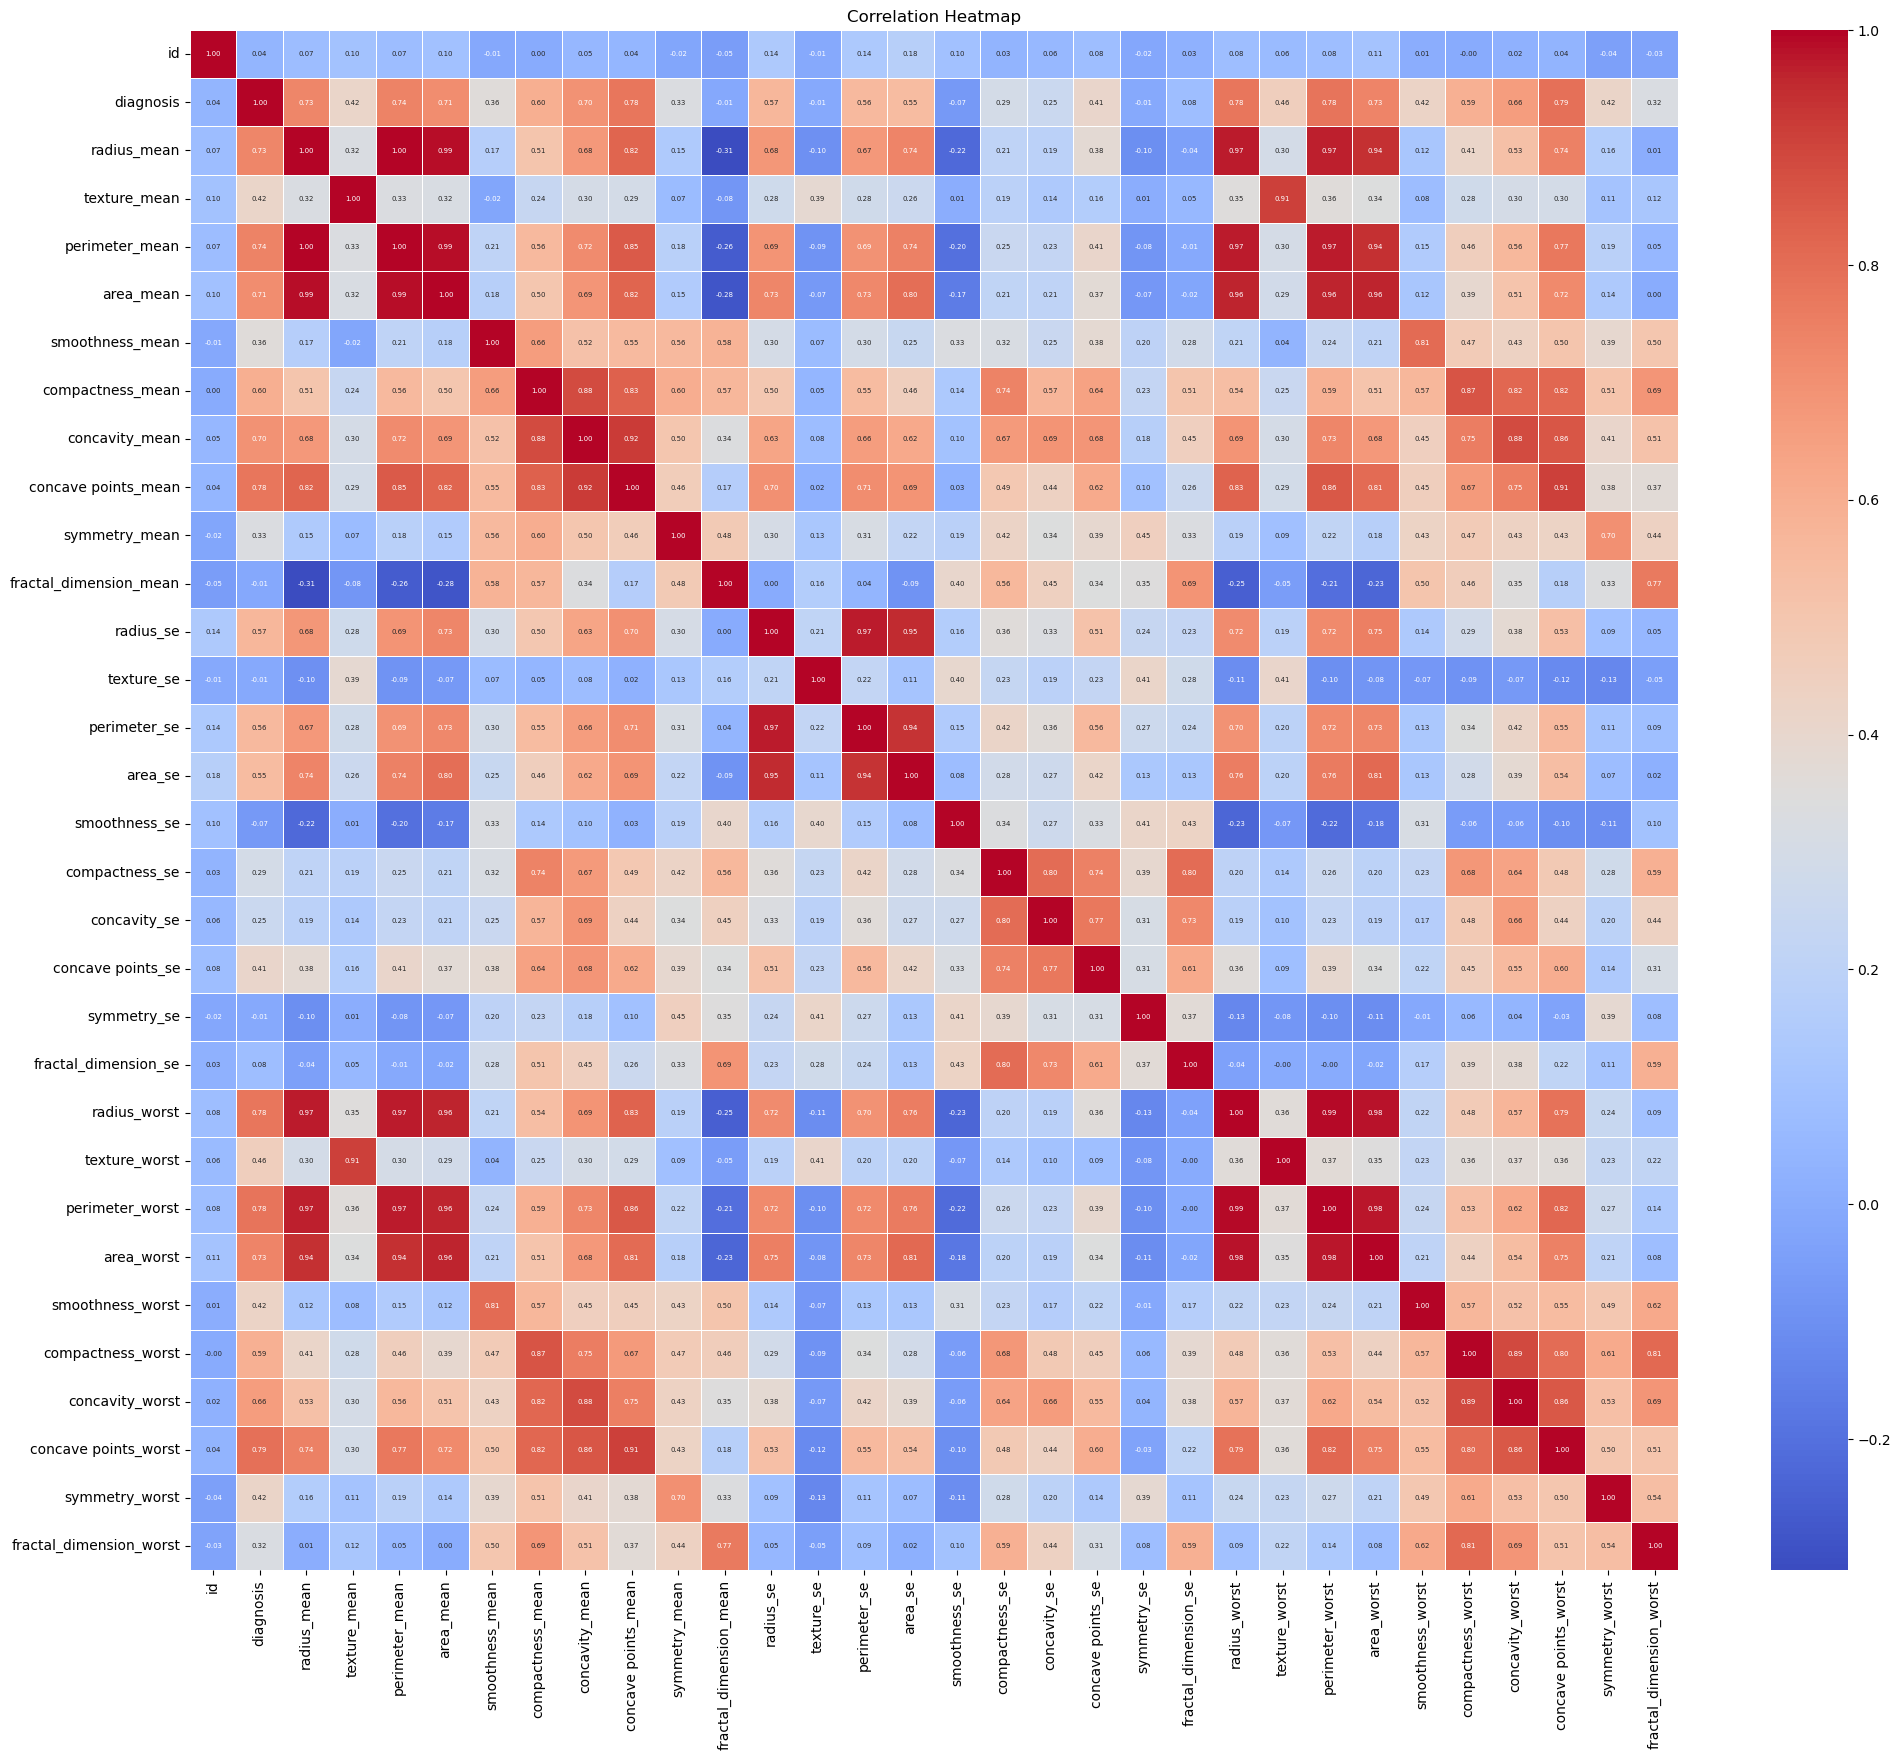

RegularLogisticRegression(): 0.971914299021891
RegularRandomForestClassifier(): 0.9595870206489675
RegularKNeighborsClassifier(): nan
PCA
3 features in LogisticRegression(): 0.9455519329296692
5 features in LogisticRegression(): 0.9631423691973297
10 features in LogisticRegression(): 0.9736686849868033
PCA
3 features in RandomForestClassifier(): 0.9315168452103709
5 features in RandomForestClassifier(): 0.9543238627542306
10 features in RandomForestClassifier(): 0.9525694767893185
PCA
3 features in KNeighborsClassifier(): 0.9367489520260829
5 features in KNeighborsClassifier(): 0.9525539512498058
10 features in KNeighborsClassifier(): 0.9578171091445427
FFS
3 features in LogisticRegression(): 0.9701288619779536
5 features in LogisticRegression(): 0.9701288619779538
10 features in LogisticRegression(): 0.9789318428815401
FFS
3 features in RandomForestClassifier(): 0.9507840397453812
5 features in RandomForestClassifier(): 0.9666200900481291
10 features in RandomForestClassifier(): 0.957

In [88]:
c_cancer
# Checking for Null Values
null_check(c_cancer)
# No Null Values present hence Encoding Categorical Data to Numerical
c_cancer = transform_data(c_cancer)
# Detailed summary of Data types in DataFrame
print(c_cancer.info())
# Plotting the heatmap
plot_Heatmap(c_cancer)
# The target column in 'diagnosis' hence applying Logistic Regression with and without CV.
c_cancer_results = ApplyClassificationMethods(c_cancer, 'diagnosis')
# display(c_cancer_results)

In [11]:
a,b,c,d,e,f = load_datasets()
a = transform_data(a)
df = ApplyClassificationMethods(a, 'diagnosis')
df

Categorical columns: Index(['diagnosis'], dtype='object')
Numerical columns: Index(['id', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')
PCA
0.9455519329296692
0.9631423691973297
0.9736686849868033
PCA
0.9350256171401956
0.9543238627542306
0.9507995652848937
PCA
0.9367489520260829
0.9525539512498058
0.9578171091445427
FFS
0.9701288619779536
0.9701288619779538
0.9789318428815401
FFS
0.9543238627542306
0.9631113181183046


,method,mean,min,max,model
0,PCA,0.9608,0.9456,0.9737,LogisticRegression
1,PCA,0.9467,0.9350,0.9543,RandomForestClassifier
2,PCA,0.9490,0.9367,0.9578,KNeighborsClassifier
3,Filter - FFS,0.9731,0.9701,0.9789,LogisticRegression
4,Filter - FFS,0.9631,0.9543,0.9719,RandomForestClassifier
5,Filter - FFS,0.9666,0.9596,0.9701,KNeighborsClassifier
6,Filter - BFE,0.9719,0.9684,0.9789,LogisticRegression
7,Filter - BFE,0.9672,0.9614,0.9736,RandomForestClassifier
8,Filter - BFE,0.9625,0.9561,0.9701,KNeighborsClassifier


### Interpretation:



## Dataset 2 : Mice Protein Expression Dataset (Classification)

Column Name: MouseID
Column DataType: int32
Column unique values: [ 45  52  53  54  55  56  57  58  59  46  47  48  49  50  51 282 289 290
 291 292 293 294 295 296 283 284 285 286 287 288 357 364 365 366 367 368
 369 370 371 358 359 360 361 362 363  15  22  23  24  25  26  27  28  29
  16  17  18  19  20  21  30  37  38  39  40  41  42  43  44  31  32  33
  34  35  36 297 304 305 306 307 308 309 310 311 298 299 300 301 302 303
 447 454 455 456 457 458 459 460 461 448 449 450 451 452 453 162 169 170
 171 172 173 174 175 176 163 164 165 166 167 168 177 184 185 186 187 188
 189 190 191 178 179 180 181 182 183 267 274 275 276 277 278 279 280 281
 268 269 270 271 272 273 477 484 485 486 487 488 489 490 491 478 479 480
 481 482 483 522 529 530 531 532 533 534 535 536 523 524 525 526 527 528
  75  82  83  84  85  86  87  88  89  76  77  78  79  80  81  90  97  98
  99 100 101 102 103 104  91  92  93  94  95  96 207 214 215 216 217 218
 219 220 221 208 209 210 211 212 213 222 229 230 231 232 2

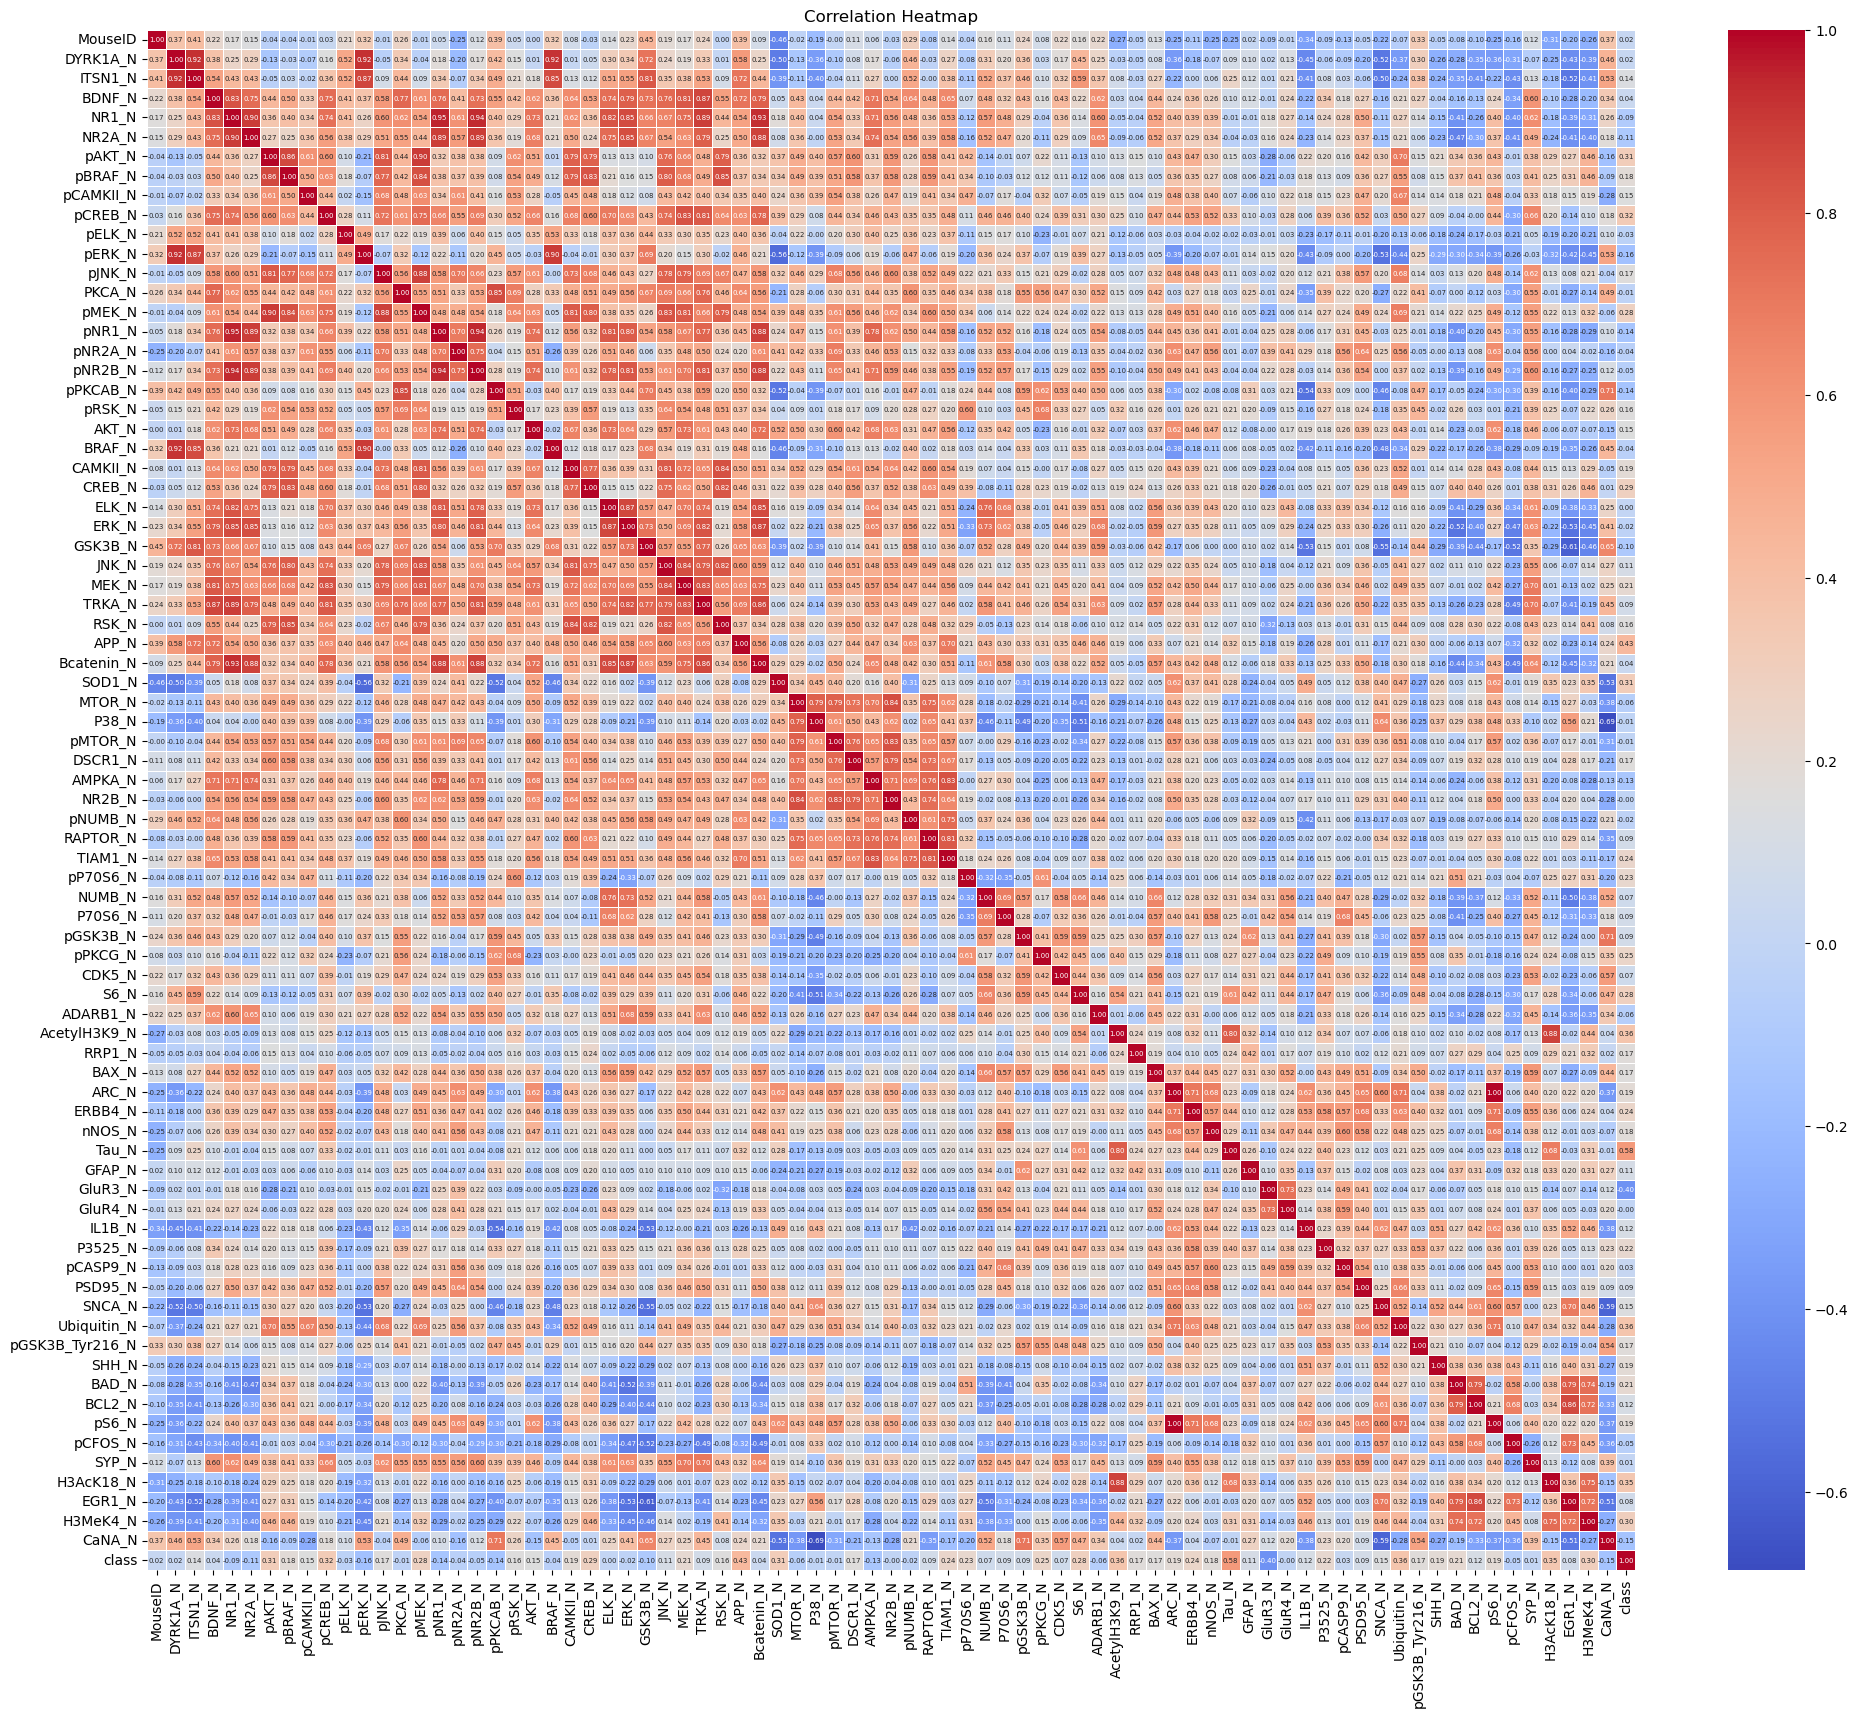

RegularLogisticRegression(): 0.9800163800163799
RegularRandomForestClassifier(): 0.9963800163800164
RegularKNeighborsClassifier(): nan
PCA
3 features in LogisticRegression(): 0.41484029484029483
5 features in LogisticRegression(): 0.5777723177723176
10 features in LogisticRegression(): 0.9365438165438166
PCA
3 features in RandomForestClassifier(): 0.8931367731367732
5 features in RandomForestClassifier(): 0.9691728091728091
10 features in RandomForestClassifier(): 0.9981818181818183
PCA
3 features in KNeighborsClassifier(): 0.9601146601146603
5 features in KNeighborsClassifier(): 0.9746273546273546
10 features in KNeighborsClassifier(): 0.9818837018837018
FFS
3 features in LogisticRegression(): 0.6703521703521703
5 features in LogisticRegression(): 0.7934479934479935
10 features in LogisticRegression(): 0.9656019656019655
FFS


In [ ]:
c_mice_expression
# Checking for Null Values
null_check(c_mice_expression)
# Null Values present hence Removing the data
clean_data(c_mice_expression,[])
# No Null Values present hence Encoding Categorical Data to Numerical
c_mice_expression = transform_data(c_mice_expression)
# Detailed summary of Data types in DataFrame
print(c_mice_expression.info())
# Plotting the heatmap
plot_Heatmap(c_mice_expression)
# The target column in 'diagnosis' hence applying Logistic Regression with and without CV.
c_mice_expression_results = ApplyClassificationMethods(c_mice_expression, 'class')
display(c_mice_expression_results)

## Dataset 3 : Adult Income Dataset (Classification)

Column Name: age
Column DataType: int64
Column has null: False


Column Name: workclass
Column DataType: object
Column unique values: ['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' nan
 'Self-emp-inc' 'Without-pay' 'Never-worked']
Column has null: True
Column Null Count: 2799


Column Name: fnlwgt
Column DataType: int64
Column has null: False


Column Name: education
Column DataType: object
Column unique values: ['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 'Assoc-voc' '7th-8th' 'Doctorate' 'Prof-school' '5th-6th' '10th'
 '1st-4th' 'Preschool' '12th']
Column has null: False


Column Name: education-num
Column DataType: int64
Column has null: False


Column Name: marital-status
Column DataType: object
Column unique values: ['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed']
Column has null: False


Column Name: occupation
Column DataType: object
Column unique values: ['Adm-

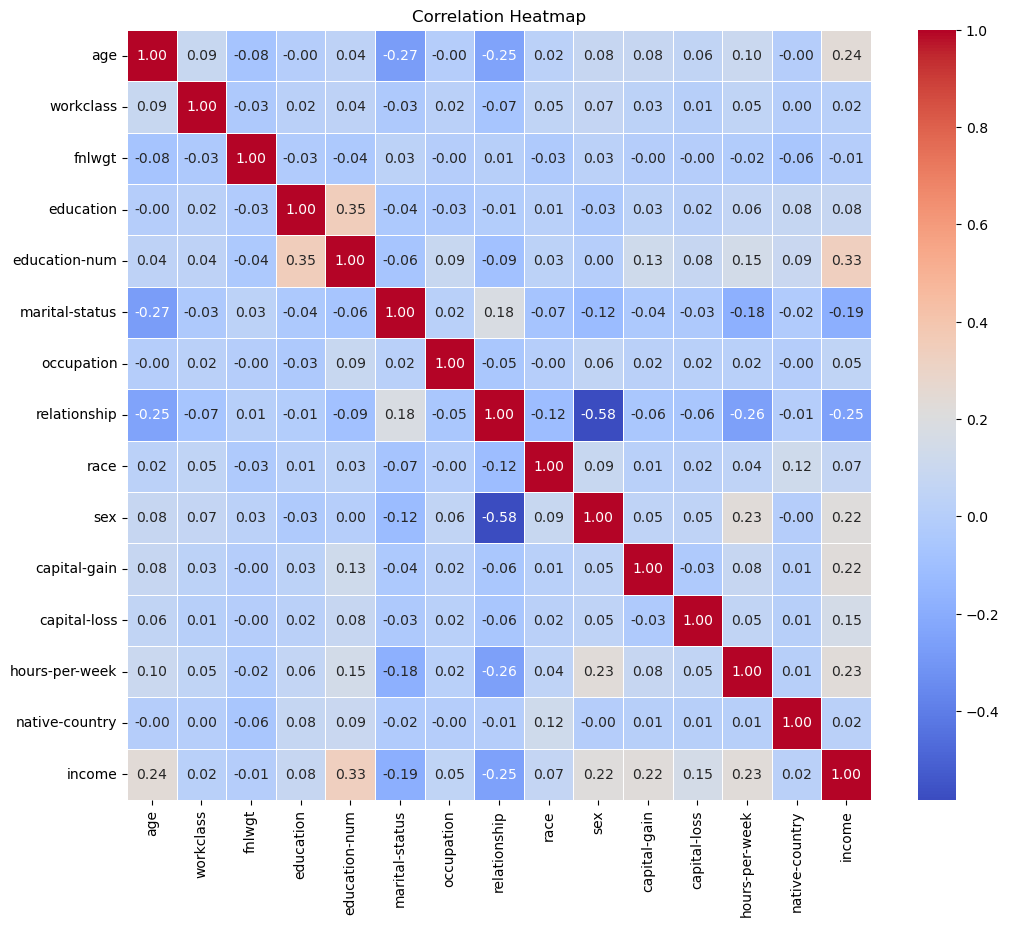

ValueError: Found input variables with inconsistent numbers of samples: [9045, 36177]

In [47]:
c_adult_income
# Checking for Null Values
null_check(c_adult_income)
# Null Values present hence Removing the data
clean_data(c_adult_income,[])
# No Null Values present hence Encoding Categorical Data to Numerical
c_adult_income = transform_data(c_adult_income)
# Detailed summary of Data types in DataFrame
print(c_adult_income.info())
# Plotting the heatmap
plot_Heatmap(c_adult_income)
# The target column in 'diagnosis' hence applying Logistic Regression with and without CV.ii
c_adult_income_results = ApplyClassificationMethods(c_adult_income, 'income', [3, 5, 10])
display(c_adult_income_results)

In [ ]:
# Function to apply correlation coefficient as filter method
def ApplyCorrelationCoefficient(X, y, k_features):
    correlation_scores = X.corrwith(y)
    correlation_scores = correlation_scores.abs().sort_values(ascending=False)
    selected_features = correlation_scores.head(k_features).index.tolist()
    return selected_features

In [ ]:
# Function to apply regression models
def ApplyRegressionModels(X_train, X_test, y_train, y_test):
    # Initialize regression models
    lr_model = LinearRegression()
    rf_model = RandomForestRegressor()
    knn_model = KNeighborsRegressor()

    # Train and evaluate Linear Regression model
    lr_model.fit(X_train, y_train)
    lr_pred = lr_model.predict(X_test)
    lr_mse = mean_squared_error(y_test, lr_pred)

    # Train and evaluate Random Forest model
    rf_model.fit(X_train, y_train)
    rf_pred = rf_model.predict(X_test)
    rf_mse = mean_squared_error(y_test, rf_pred)

    # Train and evaluate k-Nearest Neighbors model
    knn_model.fit(X_train, y_train)
    knn_pred = knn_model.predict(X_test)
    knn_mse = mean_squared_error(y_test, knn_pred)

    return lr_mse, rf_mse, knn_mse

In [ ]:
# Function to apply regression methods
def ApplyRegressionMethods(df, target_name, k_features):
    # Separate features and target variable
    X = df.drop(columns=[target_name])
    y = df[target_name]

    # Initialize k-fold cross-validation
    k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Apply ANOVA as filter method
    selected_features_anova = ApplyANOVA(X, y, k_features)

    # Apply correlation coefficient as filter method
    selected_features_corr = ApplyCorrelationCoefficient(X, y, k_features)

    # Initialize results
    results = []

    # Iterate through selected features from each method
    for selected_features in [selected_features_anova, selected_features_corr]:
        mse_lr = []
        mse_rf = []
        mse_knn = []

        # Perform cross-validation
        for train_index, test_index in k_fold.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Apply regression models
            lr_mse, rf_mse, knn_mse = ApplyRegressionModels(X_train[selected_features], X_test[selected_features], y_train, y_test)

            # Store MSE for each fold
            mse_lr.append(lr_mse)
            mse_rf.append(rf_mse)
            mse_knn.append(knn_mse)

        # Store average MSE across all folds
        results.append({
            'selected_features': selected_features,
            'LR_MSE': sum(mse_lr) / len(mse_lr),
            'RF_MSE': sum(mse_rf) / len(mse_rf),
            'KNN_MSE': sum(mse_knn) / len(mse_knn)
        })

    return pd.DataFrame(results)



In [ ]:

df_results = ApplyRegressionMethods(df, 'song_popularity', k_features=5)
print(df_results)